In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU, AUC

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIR = '/content/drive/My Drive/data/resized'
classes = [i for i in os.listdir(DIR) if '.' not in i]
classes

['Aair',
 'Boal',
 'Chapila',
 'DeshiPuti',
 'Foli',
 'Ilish',
 'KalBaush',
 'Katla',
 'Koi',
 'Magur',
 'Mrigel',
 'Pabda',
 'Pangas',
 'Puti',
 'Rui',
 'Shol',
 'Taki',
 'Tarabaim',
 'Telapiya',
 'Tengra']

In [ ]:
label = []
path = []

for dirname, _,filenames in os.walk(DIR):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.jpg':
            if dirname.split()[-1]!='GT':
                label.append(os.path.split(dirname)[-1])
                path.append(os.path.join(dirname,filename))

df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [ ]:

df.head()

path label
0  /content/drive/My Drive/data/resized/Aair/Aair...  Aair
1  /content/drive/My Drive/data/resized/Aair/Aair...  Aair
2  /content/drive/My Drive/data/resized/Aair/Aair...  Aair
3  /content/drive/My Drive/data/resized/Aair/Aair...  Aair
4  /content/drive/My Drive/data/resized/Aair/Aair...  Aair

In [ ]:
df.path[0]

'/content/drive/My Drive/data/resized/Aair/Aair328.jpg'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27176 entries, 0 to 27175
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    27176 non-null  object
 1   label   27176 non-null  object
dtypes: object(2)
memory usage: 424.8+ KB


In [ ]:
df['label'].value_counts()

label
Rui          2726
Taki         2223
Telapiya     2058
Mrigel       1808
Aair         1804
Katla        1765
Pabda        1764
Boal         1651
Puti         1560
Tengra       1431
Shol         1424
Tarabaim     1262
Ilish        1031
Pangas        934
KalBaush      917
Koi           842
Magur         574
Foli          562
Chapila       428
DeshiPuti     412
Name: count, dtype: int64

ValueError: num must be an integer with 1 <= num <= 9, not 10

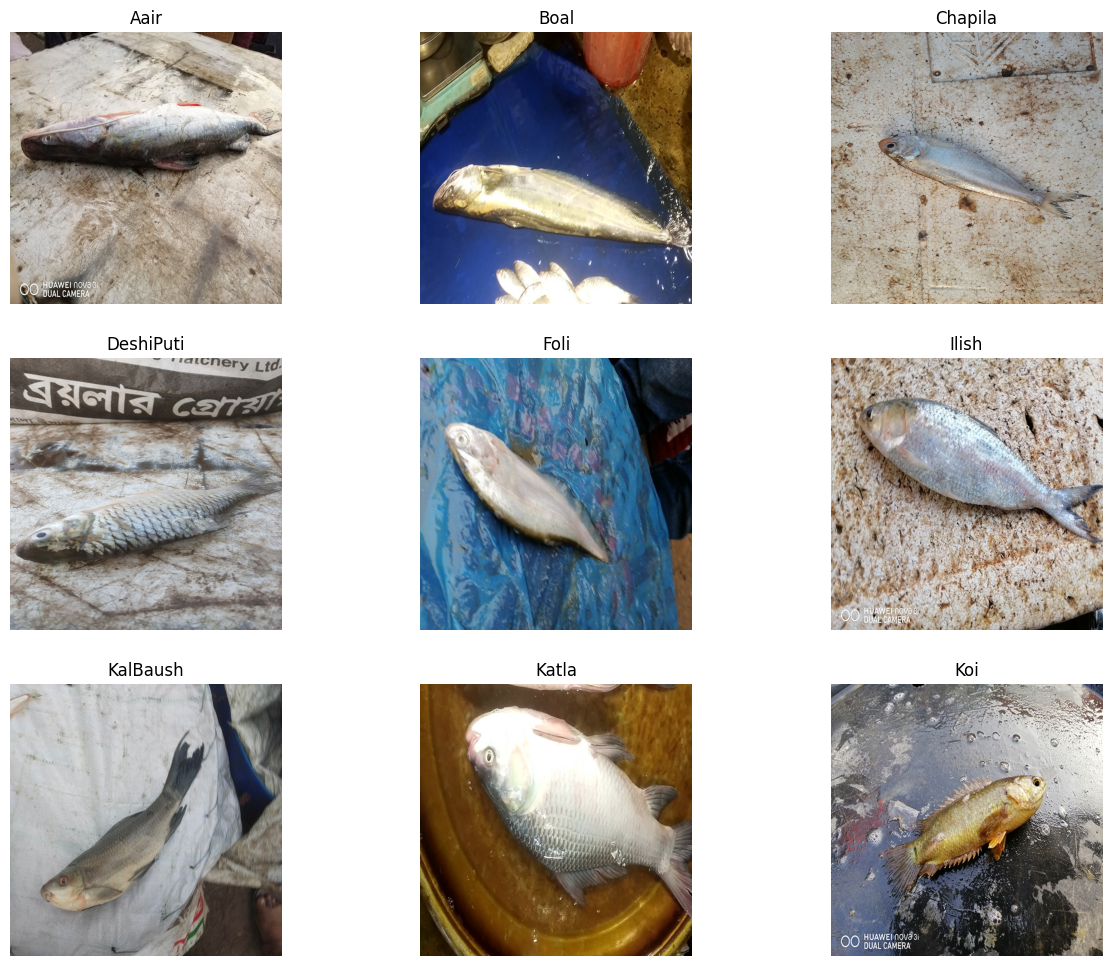

In [ ]:
idx = 0
plt.figure(figsize=(15,12))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

In [ ]:
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(21740, 2)
(5436, 2)


In [ ]:
import cv2

def enhance_contrast(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Convert to YUV color space
    yuv_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # Apply histogram equalization on the Y channel
    yuv_img[:,:,0] = cv2.equalizeHist(yuv_img[:,:,0])
    # Convert back to RGB color space
    img = cv2.cvtColor(yuv_img, cv2.COLOR_YUV2RGB)
    return img

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation' )
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False)

Found 17392 validated image filenames belonging to 20 classes.
Found 4348 validated image filenames belonging to 20 classes.
Found 5436 validated image filenames belonging to 20 classes.


In [ ]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Aair': 0,
 'Boal': 1,
 'Chapila': 2,
 'DeshiPuti': 3,
 'Foli': 4,
 'Ilish': 5,
 'KalBaush': 6,
 'Katla': 7,
 'Koi': 8,
 'Magur': 9,
 'Mrigel': 10,
 'Pabda': 11,
 'Pangas': 12,
 'Puti': 13,
 'Rui': 14,
 'Shol': 15,
 'Taki': 16,
 'Tarabaim': 17,
 'Telapiya': 18,
 'Tengra': 19}

{'Aair': 0,
 'Boal': 1,
 'Chapila': 2,
 'DeshiPuti': 3,
 'Foli': 4,
 'Ilish': 5,
 'KalBaush': 6,
 'Katla': 7,
 'Koi': 8,
 'Magur': 9,
 'Mrigel': 10,
 'Pabda': 11,
 'Pangas': 12,
 'Puti': 13,
 'Rui': 14,
 'Shol': 15,
 'Taki': 16,
 'Tarabaim': 17,
 'Telapiya': 18,
 'Tengra': 19}

{'Aair': 0,
 'Boal': 1,
 'Chapila': 2,
 'DeshiPuti': 3,
 'Foli': 4,
 'Ilish': 5,
 'KalBaush': 6,
 'Katla': 7,
 'Koi': 8,
 'Magur': 9,
 'Mrigel': 10,
 'Pabda': 11,
 'Pangas': 12,
 'Puti': 13,
 'Rui': 14,
 'Shol': 15,
 'Taki': 16,
 'Tarabaim': 17,
 'Telapiya': 18,
 'Tengra': 19}

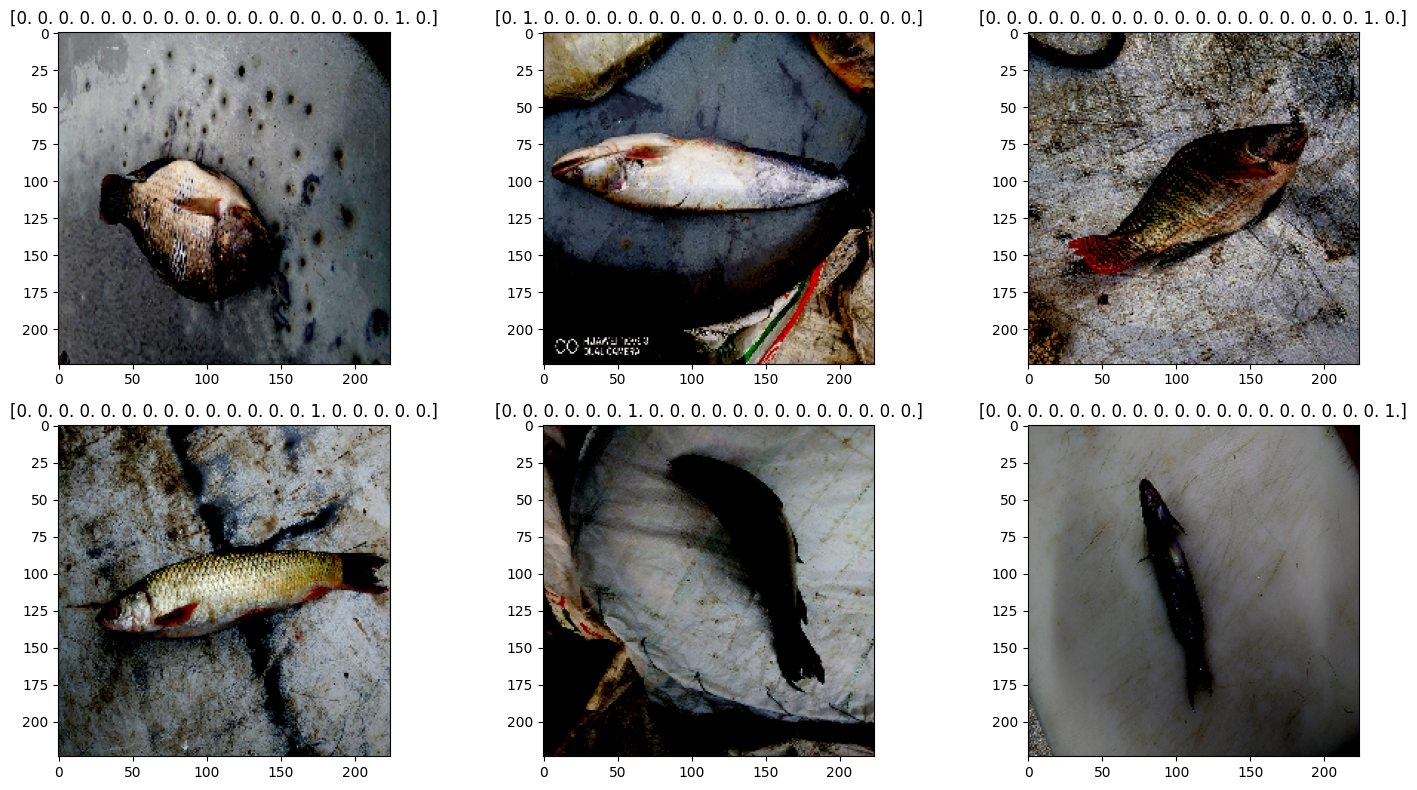

In [ ]:
fit, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax = ax.flatten()

# Loop to display 6 images
for j in range(6):
    img, label = test_images.__getitem__(j)  # Access images and labels
    ax[j].imshow(img[0])
    ax[j].set_title(label[0])
plt.tight_layout()
plt.show()


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(20, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,441,044 (9.31 MB)

 Trainable params: 183,060 (715.08 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 9609s 17s/step - accuracy: 0.7484 - loss: 0.8661 - val_accuracy: 0.9614 - val_loss: 0.1229
Epoch 2/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 1318s 2s/step - accuracy: 0.9758 - loss: 0.0815 - val_accuracy: 0.9713 - val_loss: 0.0878
Epoch 3/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 1316s 2s/step - accuracy: 0.9876 - loss: 0.0398 - val_accuracy: 0.9754 - val_loss: 0.0868
Epoch 4/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 1351s 2s/step - accuracy: 0.9912 - loss: 0.0284 - val_accuracy: 0.9770 - val_loss: 0.0690
Epoch 5/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 1346s 2s/step - accuracy: 0.9909 - loss: 0.0294 - val_accuracy: 0.9823 - val_loss: 0.0628


In [ ]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.08018
Test Accuracy: 97.74%


In [ ]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

pred_df=pred_df.reset_index(drop=True)
pred_df.head(10)

170/170 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step


path      label       pred
0  /content/drive/My Drive/data/resized/Telapiya/...   Telapiya   Telapiya
1  /content/drive/My Drive/data/resized/Puti/Puti...       Puti       Puti
2  /content/drive/My Drive/data/resized/Telapiya/...   Telapiya   Telapiya
3  /content/drive/My Drive/data/resized/KalBaush/...   KalBaush   KalBaush
4  /content/drive/My Drive/data/resized/Pabda/Pab...      Pabda      Pabda
5  /content/drive/My Drive/data/resized/Taki/Taki...       Taki       Taki
6  /content/drive/My Drive/data/resized/Tarabaim/...   Tarabaim   Tarabaim
7  /content/drive/My Drive/data/resized/Mrigel/Mr...     Mrigel     Mrigel
8  /content/drive/My Drive/data/resized/DeshiPuti...  DeshiPuti  DeshiPuti
9  /content/drive/My Drive/data/resized/Telapiya/...   Telapiya   Telapiya

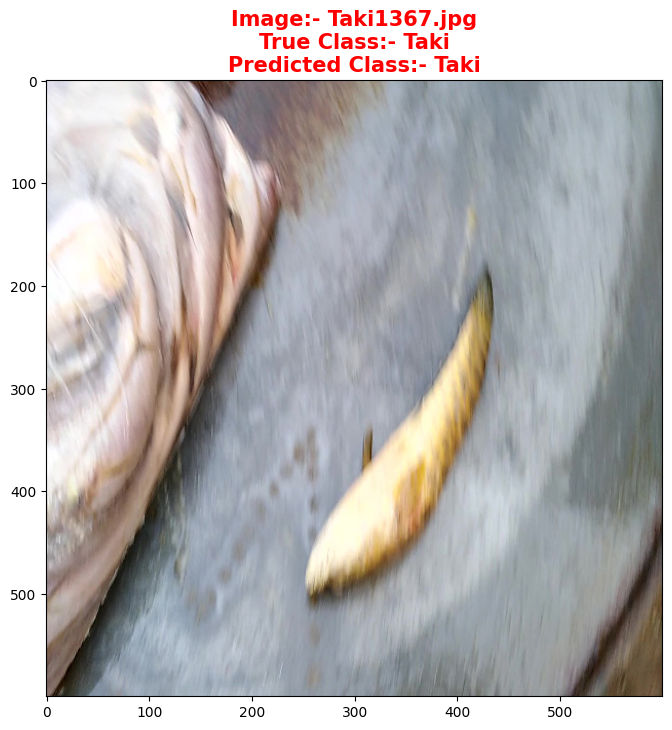

In [ ]:
pred_df[pred_df['label']!=pred_df['pred']]

pred_df.path[1604]

plt.figure(figsize=(15,8))
plt.imshow(plt.imread(pred_df.path[1604]))
title1 = pred_df.path[1604].split('/')[-2]
title2 = pred_df.path[1604].split('/')[-1]
title3 = pred_df.pred[1604]
plt.title(f'Image:- {title2}\nTrue Class:- {title1}\nPredicted Class:- {title3}', color = 'r', weight = 'bold', fontsize = 15)
plt.show()

Accuracy Score: 0.9773730684326711


<Axes: >

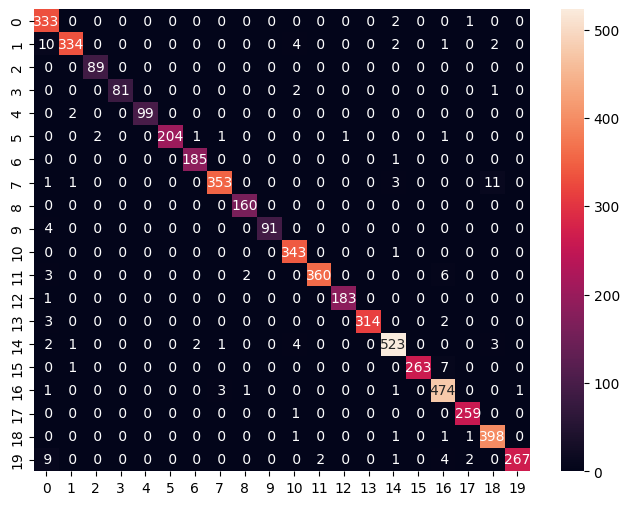

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['label'],pred_df['pred'])}")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred_df['label'],pred_df['pred']), annot=True, fmt='2d')

In [ ]:
print(classification_report(pred_df['label'],pred_df['pred']))

              precision    recall  f1-score   support

        Aair       0.91      0.99      0.95       336
        Boal       0.99      0.95      0.97       353
     Chapila       0.98      1.00      0.99        89
   DeshiPuti       1.00      0.96      0.98        84
        Foli       1.00      0.98      0.99       101
       Ilish       1.00      0.97      0.99       210
    KalBaush       0.98      0.99      0.99       186
       Katla       0.99      0.96      0.97       369
         Koi       0.98      1.00      0.99       160
       Magur       1.00      0.96      0.98        95
      Mrigel       0.97      1.00      0.98       344
       Pabda       0.99      0.97      0.98       371
      Pangas       0.99      0.99      0.99       184
        Puti       1.00      0.98      0.99       319
         Rui       0.98      0.98      0.98       536
        Shol       1.00      0.97      0.99       271
        Taki       0.96      0.99      0.97       481
    Tarabaim       0.98    